## Building the graph

### Clipping: Considerating only Python and Javascript mentions

After getting and parsing the data, we need to understand and create metrics that could lead us to our hypothesis and it's impacts.

In [129]:
from netpixi.integration.gt import Graph
import pandas as pd
import numpy as np

g = Graph(directed=False)

In [130]:
data = pd.read_csv("../data/colaboration_comments.csv")

In [131]:
# Add the source repositories (usually belonging to organizations where users collaborate)
data['source'] = list(map(lambda x : x.split("https://github.com/")[-1].split('/')[0],data['URL']))

In [132]:
#Considerating only Python and Javascript mentions
data = data[data['BODY'].notna() & (data['BODY'].str.lower().str.contains('python|py', case=False) | data['BODY'].str.lower().str.contains('javascript|js', case=False))]

In [133]:
# Drop columns which we won't use
data = data.drop(['COMMIT_ID','COMMENT_ID','URL'],axis=1)

In [134]:
#First view of data
data

,AUTHOR,CREATED_AT,BODY,source
19,CarlosX,2015-01-01T00:12:02Z,Happy new year! xD,Arctium
22,orenyk,2015-01-01T00:13:41Z,any reason why we're not excluding `vendor` he...,YaleSTC
23,foosel,2015-01-01T00:13:42Z,The new app api keys are documented [here](htt...,alexrj
33,jc00ke,2015-01-01T00:18:37Z,"```ruby\r\nbody = {\r\n name: ""event"",\r\n s...",botandrose
42,codeschool-kiddo,2015-01-01T00:22:52Z,Looks good! Could you also please mention your...,deadlyvipers
...,...,...,...,...
635126,rexxarM,2015-02-28T08:48:18Z,@kennytm does iOS support this way to invoke ...,hihex
635146,kennytm,2015-02-28T08:55:51Z,iOS WebView supports this if the via URL captu...,hihex
635180,ace2nutzer,2015-02-28T09:06:51Z,thank u....\r\n\r\nroot@codinap:/ # cat /proc/...,ace2nutzer
635221,RaMMicHaeL,2015-02-28T09:24:03Z,"Yes, you're right. My bad. Sorry for saying no...",TsudaKageyu


In [135]:
#Looking to the total contribuitions for the users in the source repositories
total_contributions = data.groupby(['AUTHOR']).count()['source'].sort_values(ascending=False)
total_contributions

AUTHOR
jirikuncar          1398
codeschool-kiddo     768
mister-roboto        484
linthubot            432
stvstnfrd            138
                    ... 
gmalette               1
gmahomar               1
gmac                   1
glynnis                1
jef-n                  1
Name: source, Length: 12414, dtype: int64

In [136]:
# As we can see there are many contribuitors who participated much less than the average, we're going to use this to filter 
# the data: contribuitors who has less contributions than the average will not be considered for the network
total_contributions.describe()

count    12414.000000
mean         3.004108
std         16.171632
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       1398.000000
Name: source, dtype: float64

In [137]:
#Cleaning the data as explaneid above
contribuitors = data.groupby(['source']).count()['AUTHOR'].sort_values(ascending=False)
contribuitors_mean = contribuitors.mean()
repos_edge = contribuitors[contribuitors>contribuitors_mean]
repos_edge.index

Index(['jirikuncar', 'deadlyvipers', 'mozilla', 'edx', 'plone', 'mozilla-b2g',
       'apache', 'iojs', 'nl5887', 'GoogleCloudPlatform',
       ...
       'roots', 'iBaa', 'kristjanmik', 'drewpts', 'GreenSteam',
       'PersonalGenomesOrg', 'dkorolev', 'ericniebler', 'driftyco',
       'iminurnamez'],
      dtype='object', name='source', length=1312)

In [138]:
#filtering
data_clean = data[data['source'].isin(repos_edge.index)]

In [139]:
data_clean

,AUTHOR,CREATED_AT,BODY,source
22,orenyk,2015-01-01T00:13:41Z,any reason why we're not excluding `vendor` he...,YaleSTC
42,codeschool-kiddo,2015-01-01T00:22:52Z,Looks good! Could you also please mention your...,deadlyvipers
45,mnquintana,2015-01-01T00:23:59Z,It seemed to be a bug with jshint's globbing -...,YaleSTC
50,j2sol,2015-01-01T00:26:09Z,Looks like copypasta. a2dissite_binary in the ...,blueboxgroup
260,berkerpeksag,2015-01-01T01:43:01Z,I'd start with `$ PYTHONPATH=. python ...` here.,spotify
...,...,...,...,...
634935,kuba,2015-02-28T07:31:52Z,For the time being I follow the policy that on...,letsencrypt
635058,ahmedre,2015-02-28T08:28:40Z,this is possibly a hack - open to suggestions ...,square
635061,kuba,2015-02-28T08:30:06Z,That's because we want to use `cls.from_valid_...,letsencrypt
635113,mrjoelkemp,2015-02-28T08:43:50Z,What about 'index.js' as a path? Wouldn't that...,mrjoelkemp


We already have the filter to build the network with a good context to define an edge between two collaborators: 

**There are an edge between them if they have at least one collaboration in a relevant source**

Even so, there many developers who collaborate very little, and we need to adjust our data to maintain only developers with a appropriate average frequency in mass of data to avoid any bias due collators with less interactions than the average of collaborations.

In [140]:
#Contributions to define an edge
edge_contrib = data_clean.groupby(['AUTHOR']).count()['source'].sort_values(ascending=False)
#Average contributions
average_contrib =edge_contrib.mean()

## Defining focus

We now need to define a custom metric to help to define our hypothesis: 

**As much a developers belong to a community (obtained by cluster coefficient metric), he has focus in the collaborations**

That way we need to define the concept of focus. Focus will be understanding in this context by: 

*Number of developer collaborations considered for edge formation divided per total collaborations in the data, thoughtful by the Number of developer collaborations per the max Number of collaborations of an individual:*

 $$focus = \frac{edgeContributions_i}{totalContributions_i}\cdot\frac{edgeContributions_i}{maxEdgeContribution}$$
 
 This metric is interesting because as define the percentage of relevant contributions to the graph, it takes into account the quantity of the individual contributions of the developer, giving different weights to them, even the  percentage of relevant contributions is similar, deepening the relevance of this metric.

In [141]:
focus = (edge_contrib/total_contributions)*(edge_contrib/np.max(edge_contrib))
focus = focus.dropna().sort_values(ascending=True)
focus

AUTHOR
rszalski            0.000080
maxogden            0.000102
M4rtinK             0.000119
Memphiz             0.000119
d10                 0.000143
                      ...   
stvstnfrd           0.098783
linthubot           0.299294
mister-roboto       0.346457
codeschool-kiddo    0.549749
jirikuncar          0.999285
Name: source, Length: 6149, dtype: float64

## Building the Network properly

To the define the network we need to enumerate the collaborators who interact in the same repo by repo, and after it set pairs of developers to create an edge in the network. 

Concurrently we are defining the focus of each developer.

In [142]:
same_repo_colab = data_clean.groupby('source')['AUTHOR'].apply(lambda x: list(np.unique(x)))
same_repo_colab

source
18F               [DavidEBest, afeld, cmc333333, cpapazian, esgo...
201-created                              [bantic, iezer, redyaffle]
2600hz                     [cando-1p, jamesaimonetti, macpie, vccs]
28msec                                       [dknochen, wcandillon]
2gis                                          [NickAb, RLRR, Trufi]
                                        ...                        
znc                                [DarthGandalf, Kriechi, jpnurmi]
zooniverse              [aweiksnar, camallen, chrissnyder, edpaget]
zopefoundation             [davisagli, freddrake, mgedmin, tseaver]
zotero            [apcshields, aurimasv, dstillman, fbennett, ne...
zxqfox                                              [eGavr, zxqfox]
Name: AUTHOR, Length: 1312, dtype: object

In [143]:
import itertools
import warnings
warnings.filterwarnings('ignore') 

g.add_vp('focus')
g.add_vp('colabs')
for index, row in same_repo_colab.iteritems():
    pairs = itertools.combinations(row, 2)
    for i,pair in enumerate(pairs):
        try:
            g.add_vertex(pair[0])
            u = g.get_vertex(pair[0])
            u['focus'] = focus[pair[0]]
            u['colabs'] = int(edge_contrib[pair[0]])
        except Exception as inst:
            pass
        try:
            g.add_vertex(pair[1])
            v = g.get_vertex(pair[1])
            v['focus'] = focus[pair[1]]
            v['colabs'] = int(edge_contrib[pair[1]])
        except Exception as inst:
            pass
        finally:
            try:
                g.add_edge(pair[0],pair[1])
            except:
                pass

#### Number of vertex in the graph

In [144]:
n = g.num_vertices()
print("g's number of vertex:", n)

g's number of vertex: 6091


#### Number of edges in the graph

In [145]:
m = g.num_edges()
print("g's number of edges:", m)

g's number of edges: 54708


#### Density of the graph

In [146]:
if g.is_directed():
    max_edges = n * (n - 1)
else:
    max_edges = n * (n - 1) // 2
max_edges

18547095

In [147]:
d = m / max_edges
d
print(f'Density is {d}')

Density is 0.0029496802599005396


### Analyzing the graph

After obtained the general data of the graph, we need to create insights by regression details which describes better if our hypothesis will be confirmed or not.

In [148]:
import seaborn as sns
from netpixi.integration.gt import *
from regression.integration.gt import *

In [149]:
data = gt_data(g)
data.head(5)

,focus,colabs
id,,
DavidEBest,0.000716,1
afeld,0.001988,5
cmc333333,0.012169,17
cpapazian,0.000716,1
esgoodman,0.001432,2


##### Adding clustering and degree metrics

In [150]:
from graph_tool import clustering

lc = clustering.local_clustering(g)
g.add_vp('clustering', lc)
dc = gt_total_degree(g)
g.add_vp('degree', dc)
data = gt_data(g)
data.describe()

,focus,colabs,clustering,degree
count,6091.000000,6091.000000,6091.000000,6091.000000
mean,0.002984,4.356920,0.878343,0.002950
std,0.016245,22.772106,0.303218,0.004453
min,0.000080,1.000000,0.000000,0.000164
25%,0.000716,1.000000,1.000000,0.000493
50%,0.001432,2.000000,1.000000,0.001149
75%,0.002863,4.000000,1.000000,0.002956
max,0.999285,1397.000000,1.000000,0.032841


In [151]:
degrees = []
for v in g.all_vertices():
    degrees.append(v.total_degree())
data['degree_count'] = degrees
data['degree_count'].describe().to_frame()

,degree_count
count,6091.000000
mean,17.963553
std,27.116848
min,1.000000
25%,3.000000
50%,7.000000
75%,18.000000
max,200.000000


<AxesSubplot: xlabel='degree_count', ylabel='Count'>

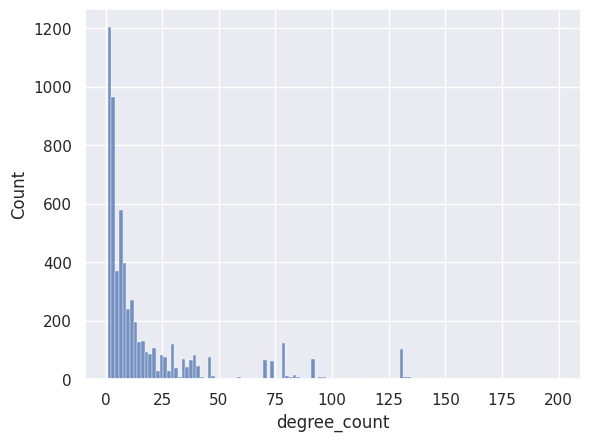

In [152]:
sns.histplot(data['degree_count'])

#### Dropping the outliers (colabs > 1000)

As we can see above there collaborators who are much higher than the collaborations, and much of them are bot's accounts (e.g *houndci* and *nrel-bot*). For this, we're removing them for the analysis.

In [153]:
selRows = data[data['colabs'] > 400].index
data = data.drop(selRows,axis=0)

### Normalizing focus

After removing the outliers we need to normalize the focus metric to properly give insights about the data.

In [154]:
x = data['focus']
x_norm = (x-np.min(x))/(np.max(x)-np.min(x)) + 1e-10 #For log issues in the next cells
data['focus'] = x_norm

In [155]:
data['degree'].describe().to_frame()

,degree
count,6087.000000
mean,0.002950
std,0.004454
min,0.000164
25%,0.000493
50%,0.001149
75%,0.002956
max,0.032841


In [156]:
data['focus'].describe().to_frame()

,focus
count,6.087000e+03
mean,2.579064e-02
std,4.290068e-02
min,1.000000e-10
25%,6.446414e-03
50%,1.369863e-02
75%,2.820306e-02
max,1.000000e+00


### Regression 

<AxesSubplot: xlabel='focus', ylabel='Count'>

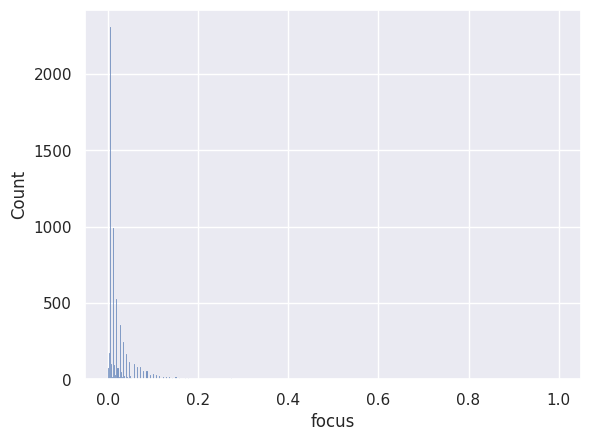

In [157]:
sns.histplot(data['focus'])

<AxesSubplot: xlabel='degree', ylabel='Count'>

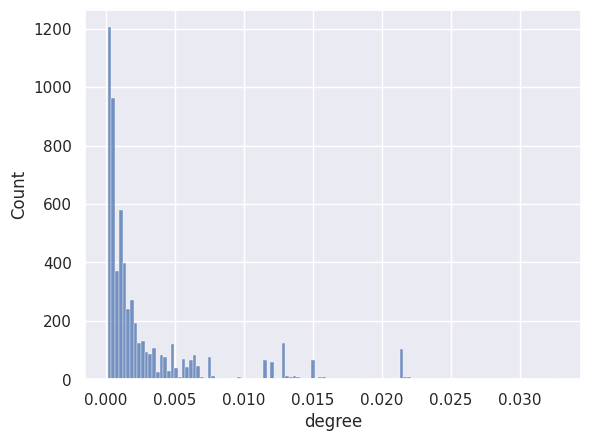

In [158]:
sns.histplot(data['degree'])

In [159]:
import seaborn as sns
import regression as reg

from scipy import stats
from matplotlib import pyplot as plt

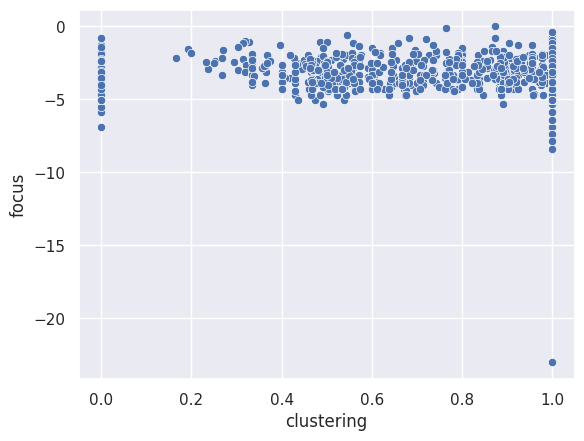

In [160]:
sns.scatterplot(x=data['clustering'], y=np.log(data['focus']));

In [161]:
data.sort_values(by="focus",ascending=False)

,focus,colabs,clustering,degree,degree_count
id,,,,,
stvstnfrd,1.000000e+00,138,0.873950,0.013957,85
kaplun,9.202256e-01,127,0.764706,0.002956,18
boegel,6.881547e-01,95,1.000000,0.001970,12
bartvm,5.656441e-01,81,0.545455,0.001806,11
sloria,4.802260e-01,71,1.000000,0.002299,14
...,...,...,...,...,...
miguelportilla,6.446415e-04,1,1.000000,0.003448,21
M4rtinK,4.029010e-04,1,1.000000,0.000821,5
Memphiz,4.029010e-04,1,1.000000,0.002299,14


### Residuals

In [162]:
result = reg.linear(data=data, formula='focus ~ clustering')

In [163]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  focus   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     74.30
Date:                Thu, 08 Jun 2023   Prob (F-statistic):           8.46e-18
Time:                        19:10:01   Log-Likelihood:                 10568.
No. Observations:                6087   AIC:                        -2.113e+04
Df Residuals:                    6085   BIC:                        -2.112e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0394      0.002     23.543      0.000       0.036       0.043
clustering    -0.0155      0.002     -8.620      0.000      -0.019      -0.012
==============================================================================
Omnibus:                     8245.369   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3009361.250
Skew:                           7.577   Prob(JB):                         0.00
Kurtosis:                     110.869   Cond. No.                         5.98
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [164]:
result.micro_summary()

variable,coefficient,std error,p-value
clustering,-0.015539,0.001803,0.000000


In [ ]:
result.plot_residuals()

#### "Massaging" the data

As we can see, the distribution of residuals is not good as we want, because the residuals has not a randomic and normal distribution to give the give the necessary confidence to the model. 

Because of this, we can apply a logaritmic scale to the focus to get a better shape and use the degree as control variable (which means the quantity of neighbors of the vertex).

In [ ]:
result = reg.linear(data=data, formula='np.log(focus) ~ clustering + degree')

In [167]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(focus)   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     205.7
Date:                Thu, 08 Jun 2023   Prob (F-statistic):           3.75e-87
Time:                        19:10:03   Log-Likelihood:                -8554.1
No. Observations:                6087   AIC:                         1.711e+04
Df Residuals:                    6084   BIC:                         1.713e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.6878      0.039    -94.894      0.000      -3.764      -3.612
clustering    -0.7484      0.042    -17.730      0.000      -0.831      -0.666
degree        35.7793      2.874     12.451      0.000      30.146      41.413
==============================================================================
Omnibus:                     1843.532   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           109639.262
Skew:                          -0.613   Prob(JB):                         0.00
Kurtosis:                      23.755   Cond. No.                         306.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [168]:
result.micro_summary()

variable,coefficient,std error,p-value
clustering,-0.748410,0.042212,0.000000
degree,35.779309,2.873701,0.000000


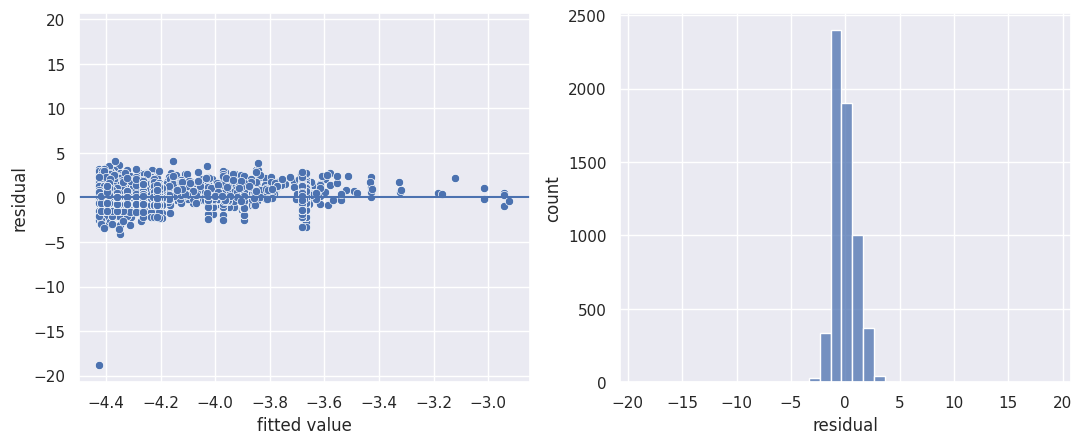

In [169]:
result.plot_residuals()

## Saving the graph

In [170]:
import netpixi

In [171]:
gt_save(g, '../networks/colabs_only_python_&_js.net.gz')